<a href="https://colab.research.google.com/github/Fikaaw/quantitative-finance/blob/main/portfolio_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Implement Markowitz Mean-Variance Optimization or other advanced techniques like the Black-Litterman model to construct an optimal investment portfolio.

[*********************100%%**********************]  4 of 4 completed


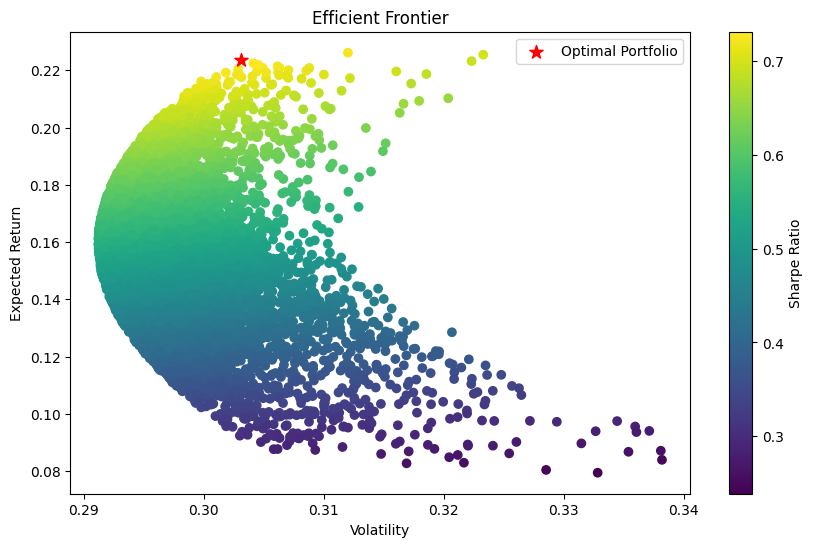

Optimal Portfolio Weights:
AAPL: 0.4521
GOOGL: 0.0000
MSFT: 0.0000
AMZN: 0.5479

Optimal Portfolio Return: 0.2238
Optimal Portfolio Volatility: 0.3031
Optimal Portfolio Sharpe Ratio: 0.7384


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def get_stock_data(tickers, start_date, end_date):
    """
    Fetch stock data from Yahoo Finance.
    """
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return data

def calculate_returns(prices):
    """
    Calculate logarithmic returns from price data.
    """
    # Use the correct method to calculate log returns
    return np.log(prices / prices.shift(1)).dropna()

def calculate_portfolio_performance(weights, returns):
    """
    Calculate portfolio performance metrics.
    """
    portfolio_return = np.sum(returns.mean() * weights) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    sharpe_ratio = portfolio_return / portfolio_volatility
    return portfolio_return, portfolio_volatility, sharpe_ratio

def negative_sharpe_ratio(weights, returns):
    """
    Calculate the negative Sharpe ratio (for minimization).
    """
    return -calculate_portfolio_performance(weights, returns)[2]

def optimize_portfolio(returns):
    """
    Perform portfolio optimization using Sharpe ratio maximization.
    """
    num_assets = returns.shape[1]
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    initial_weights = np.array([1/num_assets] * num_assets)

    optimized = minimize(negative_sharpe_ratio, initial_weights, args=(returns,),
                         method='SLSQP', bounds=bounds, constraints=constraints)

    return optimized.x

def generate_efficient_frontier(returns, num_portfolios=10000):
    """
    Generate the efficient frontier.
    """
    results = []
    num_assets = returns.shape[1]

    for _ in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        # Handle potential NaN values in Sharpe ratio calculation
        portfolio_return, portfolio_volatility, sharpe_ratio = calculate_portfolio_performance(weights, returns)
        if np.isnan(sharpe_ratio):
            continue  # Skip portfolios with undefined Sharpe ratios
        results.append([portfolio_return, portfolio_volatility, sharpe_ratio, weights])

    return pd.DataFrame(results, columns=['Return', 'Volatility', 'Sharpe', 'Weights'])

def plot_efficient_frontier(results, optimal_portfolio):
    """
    Plot the efficient frontier and the optimal portfolio.
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(results['Volatility'], results['Return'], c=results['Sharpe'], cmap='viridis')
    plt.colorbar(label='Sharpe Ratio')
    plt.xlabel('Volatility')
    plt.ylabel('Expected Return')
    plt.title('Efficient Frontier')

    optimal_return, optimal_volatility, _ = optimal_portfolio
    plt.scatter(optimal_volatility, optimal_return, c='red', s=100, marker='*', label='Optimal Portfolio')

    plt.legend()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Define stock tickers and date range
    tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN']
    start_date = '2018-01-01'
    end_date = '2023-01-01'

    # Fetch stock data and calculate returns
    stock_data = get_stock_data(tickers, start_date, end_date)
    returns = calculate_returns(stock_data)

    # Optimize portfolio
    optimal_weights = optimize_portfolio(returns)
    optimal_portfolio = calculate_portfolio_performance(optimal_weights, returns)

    # Generate efficient frontier
    results = generate_efficient_frontier(returns)

    # Plot efficient frontier
    plot_efficient_frontier(results, optimal_portfolio)

    # Print optimal portfolio details
    print("Optimal Portfolio Weights:")
    for ticker, weight in zip(tickers, optimal_weights):
        print(f"{ticker}: {weight:.4f}")
    print(f"\nOptimal Portfolio Return: {optimal_portfolio[0]:.4f}")
    print(f"Optimal Portfolio Volatility: {optimal_portfolio[1]:.4f}")
    print(f"Optimal Portfolio Sharpe Ratio: {optimal_portfolio[2]:.4f}")